In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
import pickle
import os

In [2]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score,classification_report,confusion_matrix

In [3]:
# Uso de pkl para cargar resultados de preprocesamiento
carpeta_actual = os.getcwd()

directorio = os.path.dirname(carpeta_actual)
ruta_archivo = os.path.join(directorio, 'preprocessing','resultado_df.pkl')

df=pickle.load(open(ruta_archivo, "rb"))
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,5,3,1,0,2,2,2,1,6,1,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
1,5,7,1,3,1,2,2,1,6,1,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
2,3,7,1,3,2,0,2,1,6,1,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
3,4,0,1,1,2,2,2,1,6,1,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
4,5,7,1,3,2,2,0,1,6,1,...,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,3,0,1,6,2,0,2,0,7,0,...,1,999,0,0,-1.1,94.767,-50.8,1.028,4963.6,1
41182,2,10,2,0,2,0,2,0,7,0,...,1,9,1,1,-1.1,94.767,-50.8,1.028,4963.6,0
41184,4,1,1,5,2,2,2,0,7,0,...,1,999,0,0,-1.1,94.767,-50.8,1.028,4963.6,0
41185,5,5,1,6,2,0,2,0,7,0,...,2,999,0,0,-1.1,94.767,-50.8,1.028,4963.6,0


In [4]:
X = df.drop('y',axis=1)
y = df['y']

In [5]:
from imblearn.under_sampling import NearMiss

In [6]:
X.shape

(40714, 20)

In [6]:
sm =NearMiss(version=2)
X_res , Y_res = sm.fit_resample(X,y)
pd.Series(Y_res).value_counts()

0    4417
1    4417
Name: y, dtype: int64

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.linear_model import LogisticRegression


X_train , X_test , y_train , y_test = train_test_split(X_res, Y_res, test_size = 0.2, random_state = 10)

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Modelo Inicial

In [9]:
model_inicial = LogisticRegression().fit(X_train, y_train.ravel())
y_pred_inicial = model_inicial.predict(X_test)
print(f1_score(y_test, y_pred_inicial))

0.8903694730466385


### Optimización OPTUNA

In [17]:

def objective(trial):
    gamma = trial.suggest_float("gamma", 0.01, 10, log=True)
    c = trial.suggest_float("C", 0.01, 10, log=True)
    kernel = trial.suggest_categorical("kernel", ["rbf", "poly", "linear"])
    model = SVC(C=c, kernel=kernel, gamma=gamma).fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

def objective_lr(trial):
    # Definir los hiperparámetros a optimizar
    C = trial.suggest_loguniform('C', 0.01, 10.0)

    # Crear una instancia del clasificador Regresión Logística con los hiperparámetros sugeridos por Optuna
    logistic_regression = LogisticRegression(C=C)

    # Entrenar el modelo de Regresión Logística
    logistic_regression.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = logistic_regression.predict(X_test)

    # Calcular la precisión
    f1 = f1_score(y_test, y_pred)

    return f1

# Crear un estudio de Optuna y ejecutar la optimización de hiperparámetros
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///hp.db",
    study_name="RegLog",
    )
study.optimize(objective_lr, n_trials=100, n_jobs=-1)


[I 2023-06-20 21:56:00,085] A new study created in RDB with name: RegLog
[I 2023-06-20 21:56:00,781] Trial 2 finished with value: 0.8884848484848484 and parameters: {'C': 0.8860195221711518}. Best is trial 1 with value: 0.8906344410876134.
[I 2023-06-20 21:56:00,845] Trial 1 finished with value: 0.8906344410876134 and parameters: {'C': 1.9703640591526548}. Best is trial 1 with value: 0.8906344410876134.
[I 2023-06-20 21:56:00,973] Trial 7 finished with value: 0.8702570379436965 and parameters: {'C': 0.060181495450063655}. Best is trial 1 with value: 0.8906344410876134.
[I 2023-06-20 21:56:01,027] Trial 3 finished with value: 0.8903694730466385 and parameters: {'C': 1.0967442438125559}. Best is trial 1 with value: 0.8906344410876134.
[I 2023-06-20 21:56:01,035] Trial 5 finished with value: 0.8819951338199513 and parameters: {'C': 0.34680752258839076}. Best is trial 1 with value: 0.8906344410876134.
[I 2023-06-20 21:56:01,058] Trial 6 finished with value: 0.8903694730466385 and parameter

In [18]:
# Obtener los mejores hiperparámetros encontrados
best_params = study.best_params
best_accuracy = study.best_value

print("Mejores hiperparámetros encontrados:")
print(best_params)
print("Precisión (accuracy) correspondiente:")
print(best_accuracy)

Mejores hiperparámetros encontrados:
{'C': 2.979728216900544}
Precisión (accuracy) correspondiente:
0.8911729141475212


In [19]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(**best_params).fit(X_train, y_train.ravel())

In [26]:
pred_BestParams=model.predict(X_test)

In [32]:
print("accuracy_score: {:.2f}%".format(accuracy_score(y_test,pred_BestParams)*100) )

accuracy_score: 89.81%


In [35]:
print("f1_score: {:.2f}%".format(f1_score(y_test,pred_BestParams)*100) )

f1_score: 89.12%


In [36]:
from sklearn.metrics import recall_score
print("recall: {:.2f}%".format(recall_score(y_test,pred_BestParams)*100) )

recall: 86.71%


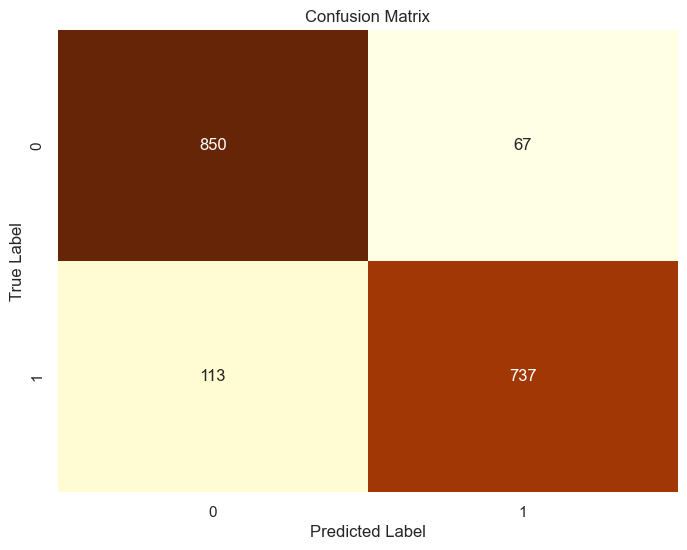

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def Matriz_Confusion(y_pred):
    sns.set(font_scale=1)
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', cbar=False, ax=ax)  
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    ax.set_title('Confusion Matrix')

    plt.show()

Matriz_Confusion(pred_BestParams)

### Optimización GridSearch

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer

g_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                  
                  #Parametros
                  param_grid = {
                              'max_features': [3,4,5,6],
                              'n_estimators': [50,100,200,250 ,300,350],
                              'criterion':('gini','entropy')
                          },                 
                  #Metrica
                  scoring='accuracy',

                  # Numero de grupos para cv
                  cv=5,
                  
                  n_jobs=-1                  
                  )

In [10]:
gs_rf=g_rf.fit(X_train, y_train)

In [11]:
gs_rf.best_params_

{'criterion': 'entropy', 'max_features': 3, 'n_estimators': 100}

In [12]:
model_rf_GSearch = RandomForestClassifier(random_state=42, n_estimators=200, max_features=5,criterion='entropy')
model_rf_GSearch.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=200,
                       random_state=42)

In [14]:
#Accuracy
print("Accuracy training tunning: {:.2f}%".format(gs_rf.best_score_ *100))

Accuracy training tunning: 88.35%


In [16]:
from sklearn.metrics import f1_score, accuracy_score,recall_score

y_test_gridRF=model_rf_GSearch.predict(X_test) 

print("accuracy_score testing tuning: {:.2f}%".format(accuracy_score(y_test,y_test_gridRF)*100) )
print("F1_Score testing tuning: {:.2f}%".format(f1_score(y_test,y_test_gridRF)*100) )
print("Recall_Score testing tuning: {:.2f}%".format(recall_score(y_test,y_test_gridRF)*100) )

accuracy_score testing tuning: 90.66%
F1_Score testing tuning: 90.13%
Recall_Score testing tuning: 88.59%


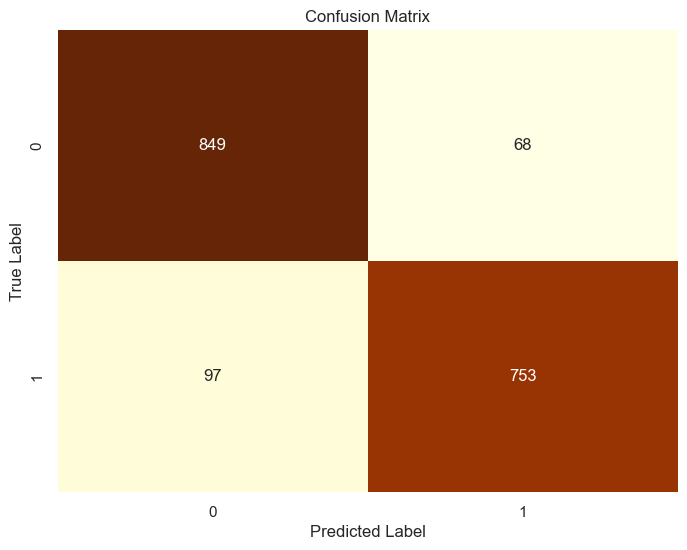

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def Matriz_Confusion(y_pred):
    sns.set(font_scale=1)
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', cbar=False, ax=ax)  # Usar 'fmt=d' para mostrar números sin notación científica
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')

    plt.show()

Matriz_Confusion(y_test_gridRF)


In [13]:
import joblib

# Guardar el modelo en un archivo
joblib.dump(model_rf_GSearch, 'model_rf_GSearch.joblib')

['model_rf_GSearch.joblib']

### Casos de Validación con FAST API

In [16]:
import numpy as np 
arreglo=model_rf_GSearch.predict(X_test)
indice = np.where(arreglo == 1)

# Verifica valor buscado
if len(indice[0]) > 0:
    # La posición del valor buscado sumando 1 al índice
    posicion = indice[0][0] + 1
    print(f"El valor 3 se encuentra en la posición {posicion}")
else:
    print("El valor 3 no se encontró en el arreglo")

El valor 3 se encuentra en la posición 7


In [14]:
X_test[0]

array([ 0.5816277 , -0.78665215,  1.14840128, -1.61822196, -2.88499896,
       -0.88546878,  0.4378378 , -0.37222741,  0.58448803, -1.53176243,
       -0.30242833, -0.65237213,  0.3687663 ,  0.80789438, -1.57878585,
       -0.15444214, -0.35537734, -0.72332961, -0.3077765 ,  0.04467111])

In [17]:
X_test[6]

array([ 1.51707671,  1.4312895 , -0.44479696,  0.44064465,  0.34662058,
       -0.88546878,  0.4378378 , -0.37222741,  1.02024886,  0.65157059,
        1.39273427, -0.65237213,  0.3687663 , -0.59801293,  0.19587291,
        1.17372708,  0.18141604, -0.00803464,  1.80963207,  1.58128515])